In [6]:
import torch as t
import numpy as np
import math
from matplotlib import pyplot as plt
from dataclasses import dataclass
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [7]:
@dataclass
class CNNArgs:
    batch_size = 64
    lr = 0.01
    epochs = 3
    img_dim = 28

args = CNNArgs()

In [8]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False,)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 316kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.71MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.37MB/s]


In [11]:
class CNN(t.nn.Module):
    def __init__(self, args):
        super().__init__()
        self.layers = t.nn.Sequential(
            t.nn.Conv2d(1, 4, 3, padding='same'),
            t.nn.ReLU(),
            t.nn.MaxPool2d(2, 2),
            t.nn.Flatten(),
            t.nn.Linear(14*14*4, 64),
            t.nn.ReLU(),
            t.nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.layers(x)

    def extra_repr(self):
        pass


class FeedForward(t.nn.Module):
    def __init__(self, args):
        super().__init__()
        self.layers = t.nn.Sequential(
            t.nn.Flatten(),
            t.nn.Linear(28*28, 64),
            t.nn.ReLU(),
            t.nn.Linear(64, 10),
            # t.nn.Softmax()
        )

    def forward(self, x):
        return self.layers(x)

    def extra_repr(self):
        pass

In [18]:
model = FeedForward(args).to('cuda')
optimizer = t.optim.AdamW(model.parameters(), lr=args.lr)

loss_list = []
for imgs, labels in tqdm(train_loader):
    imgs = imgs.to('cuda')
    labels = labels.to('cuda')
    
    logits = model(imgs)
    loss = t.nn.functional.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_list.append(loss.item())

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:05<00:00, 175.18it/s]


In [19]:
imgs_correct = 0
imgs_seen = 0

for imgs, labels in tqdm(test_loader):
    imgs = imgs.to('cuda')
    labels = labels.to('cuda')
    
    with t.no_grad():
        logits = model(imgs)
    preds = t.argmax(logits, dim=1)

    assert preds.shape == labels.shape

    imgs_correct += t.sum(preds==labels).item()
    imgs_seen += imgs.shape[0]
    

100%|██████████| 157/157 [00:00<00:00, 200.17it/s]


In [20]:
imgs_correct / imgs_seen

0.9597

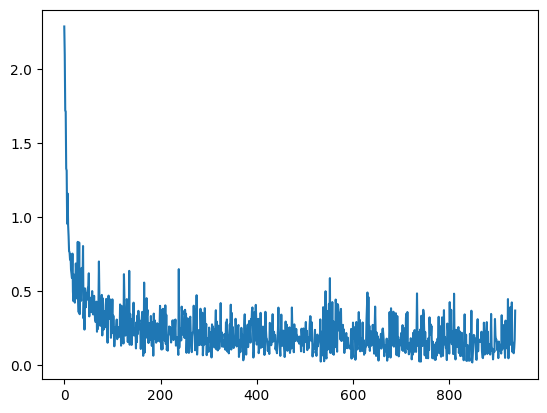

In [21]:
plt.plot(loss_list)